require "os"
require "table"
require "image"

In [21]:
function decodePNG(s)
    local data = torch.ByteTensor(torch.ByteStorage():string(s))
    return image.decompressPNG(data)
end

# sqlite3

There are multiple ways to iterate through the rows of a database.

This is probably the most efficient one, using a prepared statement and accessing the fields in the output as needed.

Note that sqlite3's outputs are numbered starting from zero, unlike Lua tables.

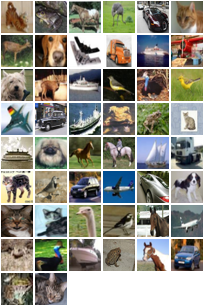

In [22]:
sqlite3 = require "lsqlite3"

db = sqlite3.open("/data/cifar10.db")
stmt = db:prepare("select * from train limit 50")
imgs = {}
clss = {}
while stmt:step() == sqlite3.ROW do
    img = decodePNG(stmt:get_value(0))
    cls = stmt:get_value(1)
    table.insert(imgs, img)
    table.insert(clss, cls)
end
stmt:finalize()
itorch.image(imgs)

# HDF5

In [23]:
require "hdf5"

h5 = hdf5.open("/data/cifar10.h5", "r")
images = h5:read("/images"):all()
classes = h5:read("/classes"):all()
print(images:size())
h5:close()

 50000
    32
    32
     3
[torch.LongStorage of size 4]



 32
 32
  3
[torch.LongStorage of size 3]

  3
 32
 32
[torch.LongStorage of size 3]



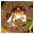

In [24]:
h5 = hdf5.open("/data/cifar10.h5", "r")
img = h5:read("/images"):partial({1,1}, {1,32}, {1,32}, {1,3})
h5:close()
print(img[1]:size())
im2 = img[1]:transpose(3,2):transpose(2,1)
print(im2:size())
itorch.image({im2})

# ZMQ and msgpack

In [25]:
require "cmsgpack"
zmq = require "lzmq"

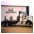

trucking_rig_s_000874.png	
48	


In [26]:
context = zmq.context()
receiver, err = context:socket{zmq.PULL, connect="tcp://172.17.0.1:11000"}
msg = receiver:recv()
batch = cmsgpack.unpack(msg)

img = decodePNG(batch["image"][1])
itorch.image({img})
print(batch["filename"][1])
print(#batch["filename"])